# 8.0 - Launch Angle Tightness
Examining the effect of launch angle "tightness" on outcomes, mainly BABIP.

## Libraries

In [1]:
import logging
import sys
import warnings

import os

import pandas as pd
import numpy as np

from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import (
    LinearRegression
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error
)

from yellowbrick.regressor import (
    PredictionError,
    ResidualsPlot
)

## Setup

In [2]:
# Supress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# BQ Logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [4]:
# BigQuery
PROJECT_ID = 'ad-fantasy-baseball'
CREDENTIALS_PATH = os.path.join(os.pardir, './credentials/mlb-db-analysis-user.json')

In [5]:
# Pandas
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [6]:
# Seaborn
sns.set(rc={'figure.figsize': (16, 9)})

## Data

In [7]:
params = {
    'min_year': 2016
}

In [40]:
SQL = \
"""
SELECT
  t_event.*,
  t_player.mlb_name AS batter_name
FROM
  (
    SELECT
      game_year,
      batter AS batter_id,
      SUM(CASE WHEN events IN ('single', 'double', 'triple') THEN 1 END) AS hits_no_hr,
      SUM(CASE WHEN events != 'home_run' THEN 1 END) AS balls_in_play,
      SUM(CASE WHEN events IN ('single', 'double', 'triple')
        AND bb_type != 'popup' THEN 1 END) AS hits_no_popup_no_hr,
      SUM(CASE WHEN events != 'home_run'
        AND bb_type != 'popup' THEN 1 END) AS balls_in_play_no_popup,
      STDDEV_POP(launch_angle) AS stdev_la,
      STDDEV_POP(CASE WHEN bb_type != 'popup' THEN launch_angle END) AS stdev_la_no_popup
    FROM
      `ad-fantasy-baseball.core.statcast`
    WHERE
      type = 'X'
        AND game_year >= {min_year}
    GROUP BY 1, 2
  ) t_event
    INNER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `ad-fantasy-baseball.core.players`
  ) t_player
    ON (t_event.batter_id = t_player.mlb_id)
"""

In [41]:
sql_base = SQL.format(**params)
df_base = read_gbq(
    query=sql_base,
    dialect='standard',
    project_id=PROJECT_ID,
    private_key=CREDENTIALS_PATH,
    configuration={'query': {'useQueryCache': False}}
)

df_copy = df_base.copy()

Requesting query... 
ok.
Query running...
Job ID: bdeeabc2-d6d9-4180-98c3-ab22a5817fff
Query running...
Got 4367 rows.

Total time taken 5.24 s.
Finished at 2019-12-08 16:01:07.


In [42]:
df_base.head(10)

,game_year,batter_id,hits_no_hr,balls_in_play,hits_no_popup_no_hr,balls_in_play_no_popup,stdev_la,stdev_la_no_popup,batter_name
0,2019,605113,122,437,122,417,28.416022,25.897136,Nick Ahmed
1,2019,592200,43,137,43,129,24.883134,22.767958,Curt Casali
2,2019,607461,60,213,60,196,26.146530,22.370217,Matt Beaty
3,2019,643446,139,411,139,386,24.487736,22.022719,Jeff McNeil
4,2019,502671,126,419,126,385,25.110070,22.107130,Paul Goldschmidt
5,2019,514917,157,502,157,460,27.687853,23.226293,Cesar Hernandez
6,2019,500743,132,422,132,406,24.156357,22.027998,Miguel Rojas
7,2019,493329,149,529,147,458,29.924860,24.210884,Yuli Gurriel
8,2019,500871,135,480,133,447,23.543546,21.213349,Eduardo Escobar
9,2019,641857,96,297,95,284,25.446096,22.738324,Ryan McMahon


## Data prep

In [43]:
# Derived columns
df_base['babip'] = df_base['hits_no_hr'] / df_base['balls_in_play']
df_base['babip_no_popup'] = df_base['hits_no_popup_no_hr'] / df_base['balls_in_play_no_popup']

In [44]:
# Filters
_min_bip = df_base['balls_in_play'] >= 100

In [45]:
df_core = df_base[_min_bip]

In [46]:
df_core.sort_values(by=['stdev_la'], ascending=True).head(10)

,game_year,batter_id,hits_no_hr,balls_in_play,hits_no_popup_no_hr,balls_in_play_no_popup,stdev_la,stdev_la_no_popup,batter_name,babip,babip_no_popup
3379,2019,595909,44,122,44,122,18.725313,18.725313,Jake Cave,0.360656,0.360656
3634,2017,488671,69,180,69,177,20.272962,19.614236,Alex Avila,0.383333,0.389831
500,2016,501896,105,282,105,279,20.551185,19.678805,David Freese,0.37234,0.376344
1684,2016,624428,42,119,42,116,20.622214,19.194509,Adam Frazier,0.352941,0.362069
2795,2016,592206,99,287,99,280,20.749642,19.857309,Nicholas Castellanos,0.344948,0.353571
297,2018,570267,54,139,54,136,20.759761,19.571542,Domingo Santana,0.388489,0.397059
3716,2016,458015,152,416,151,410,21.031252,20.478051,Joey Votto,0.365385,0.368293
3527,2018,458015,131,395,131,391,21.109180,20.711630,Joey Votto,0.331646,0.335038
1496,2016,537953,31,108,31,105,21.312265,20.716976,Daniel Nava,0.287037,0.295238
742,2018,592206,162,449,161,425,21.358782,19.224843,Nicholas Castellanos,0.360802,0.378824


## Modeling

In [75]:
def train_and_evaluate_regressor(
        df,
        label,
        features,
        model,
        test_size=0.20
    ):
    
    # Train model
    y = df[label]
    X = df[features]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    
    # Model description
    model_name = type(model).__name__
    
    if model_name == 'LinearRegression':
        print('MODEL COEFFICIENTS FOR {:s} MODEL'.format(model_name))
        
        intercept = model.intercept_
        if intercept != 0:
            print("{:30}[{:5.3f}]".format('Intercept:', intercept))
        
        for feature, weight in list(zip(features, model.coef_)):
            print("{:30}[{:5.4f}]".format(feature + ":", weight))
        print('\n')
                
    # Model metrics
    evs = explained_variance_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
        
    print('MODEL METRICS FOR {:s} MODEL'.format(model_name))
    print('Explained Variance Score: {:5.4f}'.format(evs))
    print('Mean Absolute Error: {:5.4f}'.format(mae))
    
    # Prediction Error Report
    y_test_range = abs(np.max(y_test) - np.min(y_test))

    fig, ax = plt.subplots()
    
    prediction_error = PredictionError(model, ax=ax, identity=True)
    prediction_error.fit(X_train, y_train)
    prediction_error.score(X_test, y_test)

    axis_range = [np.min(y_test) - 0.05 * y_test_range, np.max(y_test) + 0.05 * y_test_range]
    ax.set_xlim(axis_range)
    ax.set_ylim(axis_range)
    
    prediction_error.poof()

    # Residuals Plot
    fig, ax = plt.subplots()
    
    residuals_plot = ResidualsPlot(model, ax=ax, hist=False)
    residuals_plot.fit(X_train, y_train)
    residuals_plot.score(X_test, y_test)
    
    residuals_plot.poof()

### Predicting BABIP including popups

MODEL COEFFICIENTS FOR LinearRegression MODEL
Intercept:                    [0.484]
stdev_la:                     [-0.0069]


MODEL METRICS FOR LinearRegression MODEL
Explained Variance Score: 0.1775
Mean Absolute Error: 0.0285


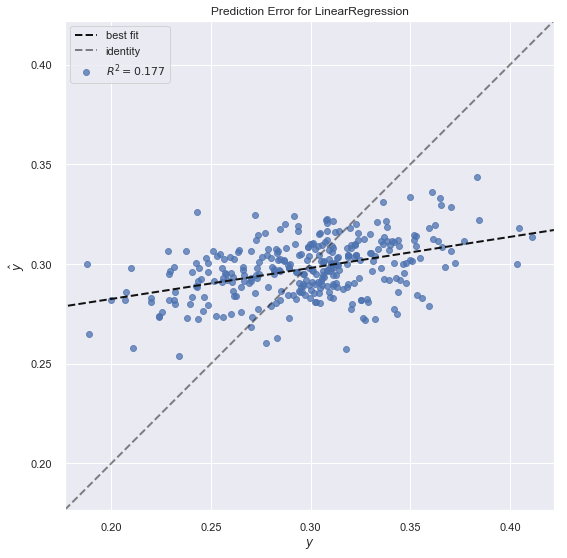

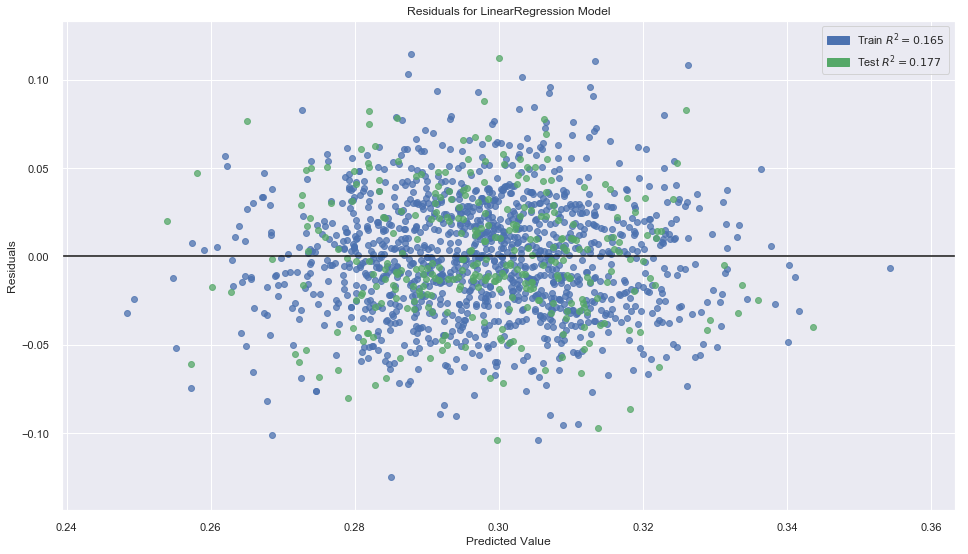

In [76]:
np_label = 'babip'
np_features = [
    'stdev_la'
]
np_model = LinearRegression(
    fit_intercept=True
)

train_and_evaluate_regressor(
    df=df_core,
    label=np_label,
    features=np_features,
    model=np_model
)

### Predicting BABIP excluding popups

MODEL COEFFICIENTS FOR LinearRegression MODEL
Intercept:                    [0.455]
stdev_la_no_popup:            [-0.0057]


MODEL METRICS FOR LinearRegression MODEL
Explained Variance Score: 0.0791
Mean Absolute Error: 0.0299


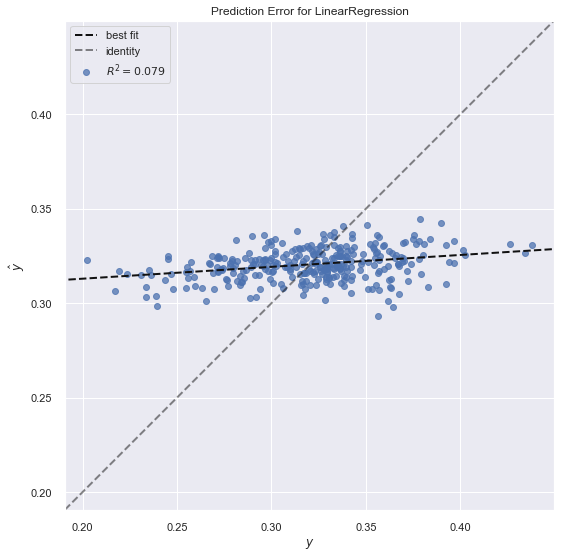

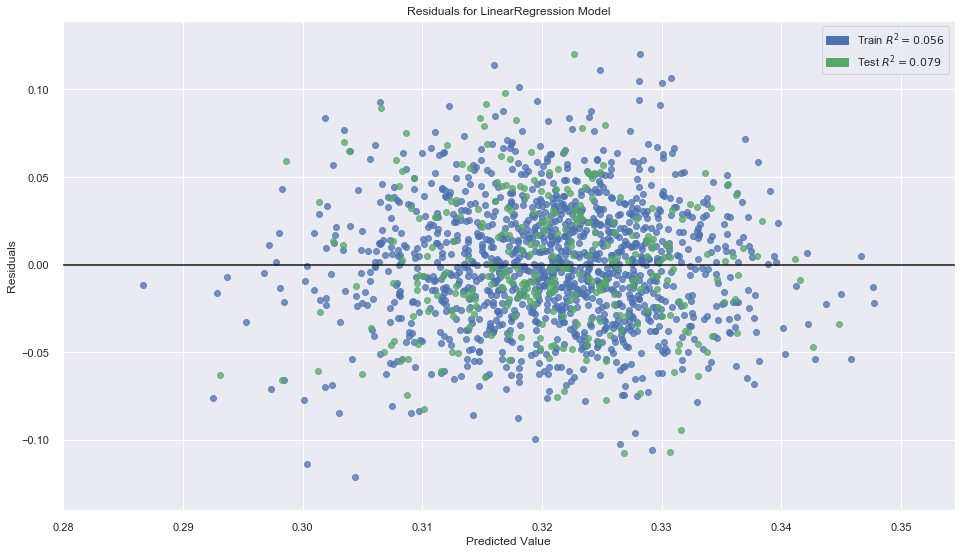

In [77]:
p_label = 'babip_no_popup'
p_features = [
    'stdev_la_no_popup'
]
p_model = LinearRegression(
    fit_intercept=True
)

train_and_evaluate_regressor(
    df=df_core,
    label=p_label,
    features=p_features,
    model=p_model
)